# 평가기준

In [ ]:
!nvidia-smi

Fri Jun 21 07:22:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     On  |   00000000:08:00.0 Off |                  N/A |
|  0%   47C    P8             14W /  182W |   16055MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## [QUEST 평가기준]

### 1. Transformer와 비교해 변경이 필요한 부분을 서술하였다.
• 제출 노트북 파일 앞부분에 텍스트 블럭으로 서술합니다. 변경이 필요한 블럭을 서술합니다.
• 코드블럭에 변경사항을 주석으로 표시합니다.

### 2. 모델의 입력 형태에 맞게 전처리를 수행하였다.
• Decoder 기반의 생성모델임을 감안하여 챗봇 데이터를 변형합니다.

### 3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정하였다.
• 모델의 input이 정상적으로 구성되었는지 확인합니다.

### 4. GPT 모델을 정상적으로 구성하였다.(model.summary, model.fit 결과 캡쳐 첨부)
• 노드의 transformer 코드를 수정하여 GPT1 모델을 구성합니다.

### 5. 입력에 따른 출력이 생성되었다.
• 출력 결과물의 수준에 상관없이 모델이 정상적으로 동작하는지 확인합니다.

In [2]:
!pwd
# /root/AIFFEL_RESEARCH_STUDY/Quests/MainQuest1_20240621/data/ChatbotData .csv

/root/AIFFEL_RESEARCH_STUDY/Quests/MainQuest1_20240621


In [4]:
import pandas as pd
import os
import re

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

In [21]:
data = pd.read_csv('~/AIFFEL_RESEARCH_STUDY/Quests/MainQuest1_20240621/data/ChatbotData.csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


# 작성 코드
## 1. Transformer와 비교해 변경이 필요한 부분을 서술하였다.
• 제출 노트북 파일 앞부분에 텍스트 블럭으로 서술합니다. 변경이 필요한 블럭을 서술합니다.
• 코드블럭에 변경사항을 주석으로 표시합니다.


- GPT1의 경우 Transformer의 Decoder에 해당하는 부분을 가져다가 사용하였음.
- 따라서, Encoder 부분이 불필요하다. 
- 또한, 학습은 Contiguous sequence of text를 진행하니까, SoS -> EoS 순차적으로 예측이 진행되어야 한다.



## 2. 모델의 입력 형태에 맞게 전처리를 수행하였다.
• Decoder 기반의 생성모델임을 감안하여 챗봇 데이터를 변형합니다.


In [38]:
len(data) # 11823개의 입력 데이터

11823

In [39]:
data.nunique()

Q        11662
A         7779
label        3
dtype: int64

In [69]:
# data의 Q, A를 중복 제거하고 합치고, label은 사용하지 않음
data_unique = data.drop_duplicates(subset=['Q', 'A'])

print(data_unique['Q'].nunique())
print(data_unique['A'].nunique())

# Q, A 합치기
merged_data = pd.concat([data_unique['Q'], data_unique['A']]).reset_index(drop=True)
merged_data.drop_duplicates(inplace=True)

print(len(merged_data))

11662
7779
19436


In [70]:
merged_data

0                          12시 땡!
1                     1지망 학교 떨어졌어
2                    3박4일 놀러가고 싶다
3                 3박4일 정도 놀러가고 싶다
4                         PPL 심하네
                   ...           
23494               진심으로 다가가 보세요.
23495          티가 나니까 눈치가 보이는 거죠!
23496               훔쳐보는 거 티나나봐요.
23497                      설렜겠어요.
23498    잘 헤어질 수 있는 사이 여부인 거 같아요.
Length: 19436, dtype: object

In [71]:
# 클리닝 진행
def preprocess_sentence(sentence):

    sentence = sentence.strip() # 양쪽 공백을 제거

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",", 한글문자)를 제외한 모든 문자를 공백인 ' '로 대체합니다. 
    sentence = re.sub("[^a-zA-Z가-힇0-9.?!,]", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [72]:
preprocess_sentence("3박4일 정도 놀러가고 싶다	")


'3박4일 정도 놀러가고 싶다'

In [73]:
merged_data = merged_data.apply(lambda x: preprocess_sentence(x))

In [74]:
merged_data.head()

0            12시 땡 !
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
dtype: object

In [75]:
# Tokenizing
import tensorflow_datasets as tfds

# Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(merged_data, target_vocab_size=2**13)

In [76]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
# 시작, 토큰에 부여된 정수를 출력
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [9050]
END_TOKEN의 번호 : [9051]


In [77]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

9052


In [79]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(merged_data[21])))


정수 인코딩 후의 21번째 질문 샘플: [8730, 1940, 3138]


In [94]:
# sos, eos 삽입
encoded_sequences = [START_TOKEN + tokenizer.encode(text) + END_TOKEN
                     for text in merged_data]

In [96]:
sequence_lengths = [len(seq) for seq in encoded_sequences]

# 최대 길이 확인
max_length = max(sequence_lengths)
d
print(f"최대 시퀀스 길이: {max_length}")

최대 시퀀스 길이: 30


In [97]:
# 최대길이 30으로 패딩 
MAX_LENGTH = 30
encoded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
      encoded_sequences, maxlen=MAX_LENGTH, padding='post')


In [98]:
# 입력 형태에 맞게 변경 - 다음단어를 예측할 수 있도록 데이터를 구성해야 합니다.

# 교사 강요
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': encoded_sequences[:, :-1]
    },
    {
        'outputs': encoded_sequences[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # 학습 시 다음 데이터 배치를 준비하도록 처리

In [100]:
len(dataset) # 304개의 배치

304


## 3. 모델의 입력 블럭을 GPT 논문에 기반하여 수정하였다.
• 모델의 input이 정상적으로 구성되었는지 확인합니다.


In [163]:
# Decoder : Masked Multihead Self Attention
# 세부 코드 수정은 개별 모듈에 주석처리를 했습니다.

from model.decoder import decoder
from model.attention import PositionalEncoding, MultiHeadAttention
from utils import utils

from utils.utils import create_padding_mask, create_look_ahead_mask, loss_function, CustomSchedule



## 4. GPT 모델을 정상적으로 구성하였다.(model.summary, model.fit 결과 캡쳐 첨부)
• 노드의 transformer 코드를 수정하여 GPT1 모델을 구성합니다.


In [164]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    
    # # encoder의 self attention
    # enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask"
    )
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    # Fisrt sub_layer : Masked Multihead Self Attention
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask        
        })
    
    # LayerNormalization
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + inputs)
    
    # # Second sub_layer : Encoder-decoder Attention
    # attention2 = MultiHeadAttention(
    #     d_model, num_heads, name="attention_2")(inputs={
    #     'query': attention1,
    #     'key': enc_outputs,
    #     'value': enc_outputs,
    #     'mask': padding_mask
    #     })
    
    # Dropout, Layer Normalization(Residual connection)
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + inputs)
    
    # Third layer : 2 Fully-connected Layer
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
        
    # Dropout, Layer Normalization(Residual connection)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2) 
    
    return tf.keras.Model(
        inputs=[inputs, 
                # enc_outputs, 
                look_ahead_mask, padding_mask], 
        outputs=outputs, 
        name=name
    )    
    
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
            )(inputs=[outputs, 
                    #   enc_outputs, 
                      look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, 
                # enc_outputs, 
                look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


In [180]:
def GPT1(vocab_size,
               num_layers,
               units,
               d_model,
               num_heads,
               dropout,
               name="gpt1"):
    # inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    # enc_padding_mask = tf.keras.layers.Lambda( # 함수 기반으로 레이어 생성
    #     create_padding_mask, # (1, 1, seq_len)의 반환값
    #     output_shape = (1, 1, None),
    #     name='enc_padding_mask')(inputs)
    
    # for decoder masking 
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    # for Decoder padding
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, 
        output_shape=(1, 1, None),
        name='dec_padding_mask')(dec_inputs)
    
    # # Encoder
    # enc_outputs = encoder(
    #     vocab_size=vocab_size,
    #     num_layers=num_layers,
    #     units=units,
    #     d_model=d_model,
    #     num_heads=num_heads,
    #     dropout=dropout,
    # )(inputs=[inputs, enc_padding_mask])
    
    # Decoder
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, 
            #   enc_outputs, 인코더 출력값을 구하지 않습니다.
              look_ahead_mask, dec_padding_mask])
    
    # Fully connected layer
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[dec_inputs], outputs=outputs, name=name)
    

In [181]:
# 현재 세션에 존재하는 모든 텐서 객체들을 삭제 - 메모리 누수 방지 및 이전에 사용된 가중치 초기화
tf.keras.backend.clear_session() 

In [182]:
# 하이퍼파리마터
NUM_LAYERS = 2 # 디코더 층의 개수
D_MODEL = 256 # 디코더 내부 입,출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1

In [183]:
model = GPT1(
    vocab_size=VOCAB_SIZE, 
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

model.summary()

Model: "gpt1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 look_ahead_mask (Lambda)       (None, 1, None, Non  0           ['dec_inputs[0][0]']             
                                e)                                                                
                                                                                                  
 dec_padding_mask (Lambda)      (None, 1, 1, None)   0           ['dec_inputs[0][0]']             
                                                                                                  
 decoder (Functional)           (None, None, 256)    3372544     ['dec_inputs[0][0]',          

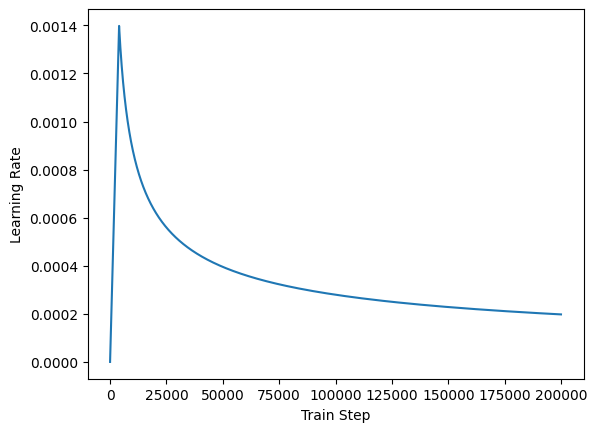

In [184]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [194]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, 
                                       MAX_LENGTH - 1)) # Time step ?
    
    if tf.__version__ >= '2.9.0' : 
            
        # print(type(mask), type(loss)) 
        # <class 'tensorflow.python.framework.ops.Tensor'> <class 'keras.losses.SparseCategoricalCrossentropy'>
        # 로컬 MacbookPro tf v2.9 기준 type의 불일치로 연산이 진행되지 않음
        
        loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            reduction='none',
            ) # 각 샘플에 대한 손실값을 반환
        
        loss = loss_obj(y_true, y_pred)
        loss = tf.cast(loss, dtype=tf.float32)
        
    
    else : 
        
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, 
            reduction='none') # 각 샘플에 대한 손실값을 반환
        (y_true, y_pred)
        
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32) # 패딩 토큰을 고려    
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss) # 실제 고려된 손실
        

In [196]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [217]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
304/304 [==============================] - 5s 16ms/step - loss: 0.7948 - accuracy: 0.0883
Epoch 2/100
304/304 [==============================] - 5s 16ms/step - loss: 0.7381 - accuracy: 0.0953
Epoch 3/100
304/304 [==============================] - 5s 16ms/step - loss: 0.6903 - accuracy: 0.1030
Epoch 4/100
304/304 [==============================] - 5s 16ms/step - loss: 0.6463 - accuracy: 0.1120
Epoch 5/100
304/304 [==============================] - 5s 16ms/step - loss: 0.5984 - accuracy: 0.1225
Epoch 6/100
304/304 [==============================] - 5s 16ms/step - loss: 0.5589 - accuracy: 0.1320
Epoch 7/100
304/304 [==============================] - 5s 16ms/step - loss: 0.5296 - accuracy: 0.1385
Epoch 8/100
304/304 [==============================] - 5s 16ms/step - loss: 0.5093 - accuracy: 0.1435
Epoch 9/100
304/304 [==============================] - 5s 16ms/step - loss: 0.4926 - accuracy: 0.1470
Epoch 10/100
304/304 [==============================] - 5s 16ms/step - loss: 0.481

In [219]:
model.save_weights('./checkpoints/gpt_ckpt')


## 5. 입력에 따른 출력이 생성되었다.
• 출력 결과물의 수준에 상관없이 모델이 정상적으로 동작하는지 확인합니다.

In [220]:
trained_model = GPT1(
    vocab_size=VOCAB_SIZE, 
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

trained_model.summary()
trained_model.load_weights('./checkpoints/gpt_ckpt')

Model: "gpt1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 look_ahead_mask (Lambda)       (None, 1, None, Non  0           ['dec_inputs[0][0]']             
                                e)                                                                
                                                                                                  
 dec_padding_mask (Lambda)      (None, 1, 1, None)   0           ['dec_inputs[0][0]']             
                                                                                                  
 decoder (Functional)           (None, None, 256)    3372544     ['dec_inputs[0][0]',          

In [234]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    print(sentence)
    
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        # predictions = trained_model(inputs=[sentence], training=False)
        predictions = model(inputs=[sentence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [235]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)
    print(prediction)
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [236]:
sentence_generation('나는 아이펠 교육을 듣고 있어.')

tf.Tensor([[9050  231 1312 9031 8936 8954 8826  982 3074   14 1632   75    1 9051]], shape=(1, 14), dtype=int32)


tf.Tensor(
[9050    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1], shape=(31,), dtype=int32)
입력 : 나는 아이펠 교육을 듣고 있어.
출력 :  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


' . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .'

- 돌아는 가게 했는데, 왜 전부 다 1로 예측을 하는지 모르겠다.

In [233]:
# 임베딩이 잘못되었나 ?
tokenizer.decode([4, 5, 7, 10, 110, 500, 1000])

'거예요너무 수 는 하면 조금만 친구를 '